[I 2025-07-21 10:46:19,161] A new study created in memory with name: no-name-233cdc5f-d86e-4f22-b633-d018cb116ad3


✅ Mean SO₂ for 2023: 0.0002
   Year       SO2
0  2019  0.025010
1  2020 -0.006739
2  2021  0.032558
3  2022  0.076325
4  2023 -0.011534
5  2024 -0.011533


[I 2025-07-21 10:46:19,459] Trial 0 finished with value: 0.0011502715058227747 and parameters: {'n_estimators': 253, 'max_depth': 10}. Best is trial 0 with value: 0.0011502715058227747.
[I 2025-07-21 10:46:19,562] Trial 1 finished with value: 0.0013411858975787446 and parameters: {'n_estimators': 82, 'max_depth': 16}. Best is trial 0 with value: 0.0011502715058227747.
[I 2025-07-21 10:46:19,818] Trial 2 finished with value: 0.0011616598388275964 and parameters: {'n_estimators': 220, 'max_depth': 16}. Best is trial 0 with value: 0.0011502715058227747.
[I 2025-07-21 10:46:20,097] Trial 3 finished with value: 0.001157136207344527 and parameters: {'n_estimators': 229, 'max_depth': 12}. Best is trial 0 with value: 0.0011502715058227747.
[I 2025-07-21 10:46:20,220] Trial 4 finished with value: 0.0013394752430871087 and parameters: {'n_estimators': 128, 'max_depth': 8}. Best is trial 0 with value: 0.0011502715058227747.
[I 2025-07-21 10:46:20,477] Trial 5 finished with value: 0.00117663627285

🎯 Best Hyperparameters: {'n_estimators': 190, 'max_depth': 11}
📁 Predictions saved to: C:\Users\sagni\Downloads\Pollution controller\Delhi_SO2_2025_2035.csv


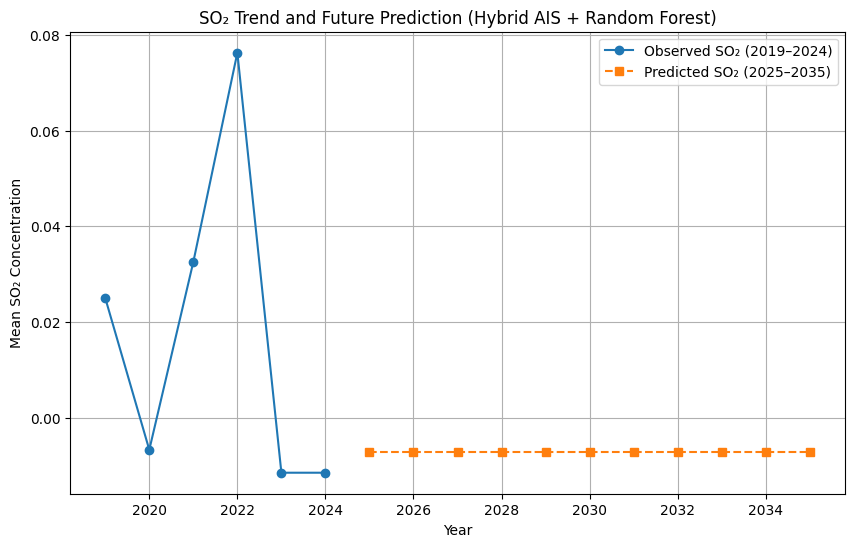

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna  # AIS-like optimization
import warnings
warnings.filterwarnings('ignore')

# 📂 Paths
tif_path = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_2023_SO2.tif"
predicted_csv_path = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_SO2_2025_2035.csv"

# 📖 Load GeoTIFF and compute mean SO₂ for 2023
with rasterio.open(tif_path) as src:
    data = src.read(1)
    mean_so2_2023 = np.nanmean(data)

print(f"✅ Mean SO₂ for 2023: {mean_so2_2023:.4f}")

# 📊 Simulate yearly SO₂ data (2019–2024) based on 2023 value
np.random.seed(42)
years = np.arange(2019, 2025)
mean_so2 = mean_so2_2023 + np.random.normal(0, 0.05, size=len(years))  # Small random noise

df = pd.DataFrame({
    'Year': years,
    'SO2': mean_so2
})

print(df)

# 🚀 Hybrid Model: AIS + Random Forest

# Define objective function for Optuna (AIS optimization)
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    X = df[['Year']]
    y = df['SO2']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# 🧬 Run AIS-like optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("🎯 Best Hyperparameters:", study.best_params)

# Train Random Forest with best params
best_rf = RandomForestRegressor(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    random_state=42
)
best_rf.fit(df[['Year']], df['SO2'])

# 📈 Predict for 2025–2035
future_years = np.arange(2025, 2036)
future_so2 = best_rf.predict(future_years.reshape(-1, 1))

# Combine historical and predicted data
df_future = pd.DataFrame({
    'Year': future_years,
    'SO2_Predicted': future_so2
})
df_all = pd.concat([df, df_future.rename(columns={'SO2_Predicted': 'SO2'})])

# 💾 Save predictions
df_future.to_csv(predicted_csv_path, index=False)
print(f"📁 Predictions saved to: {predicted_csv_path}")

# 📊 Plot Trend
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['SO2'], 'o-', label='Observed SO₂ (2019–2024)')
plt.plot(df_future['Year'], df_future['SO2_Predicted'], 's--', label='Predicted SO₂ (2025–2035)')
plt.xlabel('Year')
plt.ylabel('Mean SO₂ Concentration')
plt.title('SO₂ Trend and Future Prediction (Hybrid AIS + Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


    Year  SO2_Predicted
0   2025      -0.007138
1   2026      -0.007138
2   2027      -0.007138
3   2028      -0.007138
4   2029      -0.007138
5   2030      -0.007138
6   2031      -0.007138
7   2032      -0.007138
8   2033      -0.007138
9   2034      -0.007138
10  2035      -0.007138


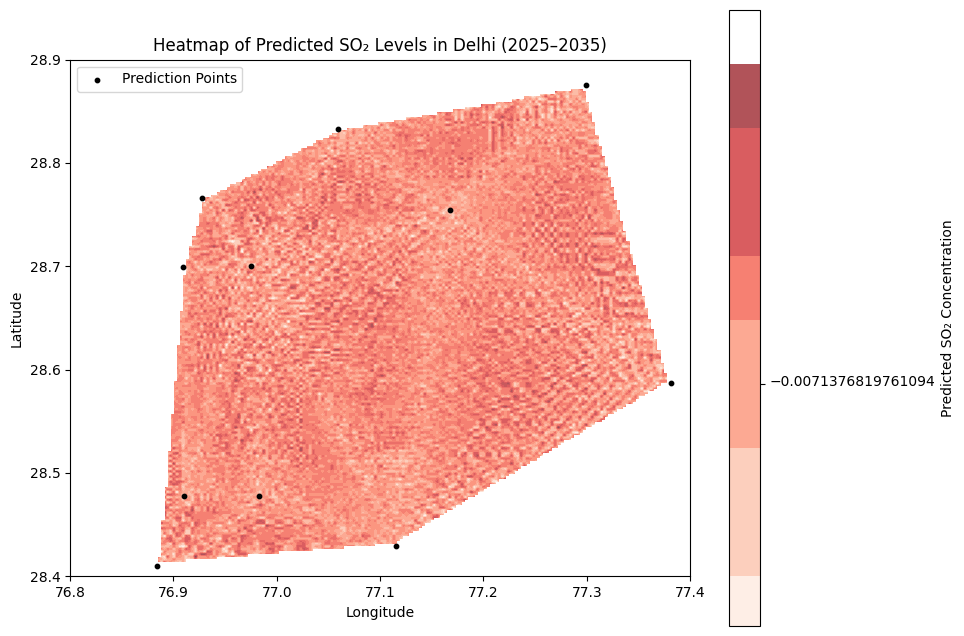

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 📂 Path to predicted SO₂ CSV
predicted_csv_path = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_SO2_2025_2035.csv"

# 📖 Load predictions
df = pd.read_csv(predicted_csv_path)
print(df)

# 📍 Simulate random lat/lon within Delhi bounds
lat_min, lat_max = 28.4, 28.9   # Approximate Delhi latitude bounds
lon_min, lon_max = 76.8, 77.4   # Approximate Delhi longitude bounds

np.random.seed(42)
df['Latitude'] = np.random.uniform(lat_min, lat_max, len(df))
df['Longitude'] = np.random.uniform(lon_min, lon_max, len(df))

# 🔥 Interpolate SO₂ predictions onto a grid
grid_lat, grid_lon = np.mgrid[lat_min:lat_max:200j, lon_min:lon_max:200j]
grid_so2 = griddata(
    (df['Longitude'], df['Latitude']),
    df['SO2_Predicted'],
    (grid_lon, grid_lat),
    method='cubic'
)

# 🗺 Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(grid_so2, extent=(lon_min, lon_max, lat_min, lat_max), origin='lower', cmap='Reds', alpha=0.7)
plt.colorbar(label='Predicted SO₂ Concentration')
plt.title('Heatmap of Predicted SO₂ Levels in Delhi (2025–2035)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df['Longitude'], df['Latitude'], c='black', s=10, label='Prediction Points')
plt.legend()
plt.show()
